In [85]:
#!pip install geopy

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from geopy.geocoders import Nominatim
import datetime
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.under_sampling import RandomUnderSampler

from imblearn.over_sampling import SMOTE
import pickle

from sklearn.cluster import DBSCAN
import folium

In [88]:
# Define the path to the folder
# folder_path = Path("C:/Users/crazy/OneDrive - The City College of New York/DSE I2100 - Applied Machine Learning and Data Mining/Project")
# csv_file = folder_path.glob("*.csv").__next__()

# Load CSV file into DataFrame
# df = pd.read_csv(csv_file)


# df = pd.read_csv('/content/drive/MyDrive/Motor_Vehicle_Collisions_-_Crashes.csv', nrows=400000)

df = pd.read_csv('/content/drive/MyDrive/Motor_Vehicle_Collisions_-_Crashes.csv')


<ipython-input-88-4dca41c7a111>:11: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Motor_Vehicle_Collisions_-_Crashes.csv')


## Data Preprocessing

In [89]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077598 entries, 0 to 2077597
Data columns (total 29 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   CRASH DATE                     2077598 non-null  object 
 1   CRASH TIME                     2077598 non-null  object 
 2   BOROUGH                        1431167 non-null  object 
 3   ZIP CODE                       1430917 non-null  object 
 4   LATITUDE                       1843830 non-null  float64
 5   LONGITUDE                      1843830 non-null  float64
 6   LOCATION                       1843830 non-null  object 
 7   ON STREET NAME                 1636440 non-null  object 
 8   CROSS STREET NAME              1292051 non-null  object 
 9   OFF STREET NAME                348785 non-null   object 
 10  NUMBER OF PERSONS INJURED      2077580 non-null  float64
 11  NUMBER OF PERSONS KILLED       2077567 non-null  float64
 12  NUMBER OF PEDE

In [90]:
df.isnull().sum()

CRASH DATE                             0
CRASH TIME                             0
BOROUGH                           646431
ZIP CODE                          646681
LATITUDE                          233768
LONGITUDE                         233768
LOCATION                          233768
ON STREET NAME                    441158
CROSS STREET NAME                 785547
OFF STREET NAME                  1728813
NUMBER OF PERSONS INJURED             18
NUMBER OF PERSONS KILLED              31
NUMBER OF PEDESTRIANS INJURED          0
NUMBER OF PEDESTRIANS KILLED           0
NUMBER OF CYCLIST INJURED              0
NUMBER OF CYCLIST KILLED               0
NUMBER OF MOTORIST INJURED             0
NUMBER OF MOTORIST KILLED              0
CONTRIBUTING FACTOR VEHICLE 1       6814
CONTRIBUTING FACTOR VEHICLE 2     322220
CONTRIBUTING FACTOR VEHICLE 3    1929123
CONTRIBUTING FACTOR VEHICLE 4    2044064
CONTRIBUTING FACTOR VEHICLE 5    2068510
COLLISION_ID                           0
VEHICLE TYPE COD

### Correcting values in # of persons injured/killed:

In [91]:
#Sum the injury-related columns
injury_columns = ['NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF MOTORIST INJURED']
df['NUMBER OF PERSONS INJURED'] = df[injury_columns].sum(axis=1)

#Sum the killed-related columns
killed_columns = ['NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST KILLED']
df['NUMBER OF PERSONS KILLED'] = df[killed_columns].sum(axis=1)

In [92]:
df[['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED']].sample(10)

,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED
655724,0,0
500167,1,0
1281827,0,0
1858698,2,0
53333,0,0
531114,0,0
159897,0,0
997162,0,0
1485376,0,0
967263,0,0


### The Following code replaces row value coordinates not in NYC with NaN for 'LATITUDE' & 'LONGITUDE' columns:

In [93]:
# Approximate coordinates for New York City:
# Maximum Latitude: 40.9176 (Northernmost point of the Bronx)
# Minimum Latitude: 40.4774 (Southernmost point of Staten Island)
# Maximum Longitude: -73.7004 (Easternmost point of Queens)
# Minimum Longitude: -74.2591 (Westernmost point of Staten Island)

# Define the maximum and minimum values for latitude and longitude
max_latitude = 40.9176
min_latitude = 40.4774
max_longitude = -73.7004
min_longitude = -74.2591

# Filter the DataFrame based on the conditions for latitude and longitude
invalid_latitudes = (df['LATITUDE'] > max_latitude) | (df['LATITUDE'] < min_latitude)
invalid_longitudes = (df['LONGITUDE'] > max_longitude) | (df['LONGITUDE'] < min_longitude)

# Replace the values with NaN where the conditions are not met
df.loc[invalid_latitudes, 'LATITUDE'] = np.nan
df.loc[invalid_longitudes, 'LONGITUDE'] = np.nan

In [94]:
print(df['NUMBER OF PERSONS INJURED'].value_counts())

NUMBER OF PERSONS INJURED
0     1609447
1      362338
2       68962
3       22648
4        8407
5        3231
6        1352
7         574
8         252
9         129
10         85
11         50
12         32
13         27
15         14
14         10
16          8
18          6
17          6
22          3
19          3
24          3
20          2
40          1
31          1
27          1
32          1
43          1
21          1
23          1
34          1
25          1
Name: count, dtype: int64


In [95]:
print(df['NUMBER OF PERSONS KILLED'].value_counts())

NUMBER OF PERSONS KILLED
0    2074662
1       2844
2         74
3         12
4          3
5          2
8          1
Name: count, dtype: int64


### Creating target column "CLASS TYPE":

In [96]:
def determine_class_type(row):
    if row['NUMBER OF PERSONS INJURED'] == 0 and row['NUMBER OF PERSONS KILLED'] == 0:
        return '0'
    else:
        return '1'

df['CLASS TYPE'] = df.apply(determine_class_type, axis=1)
df['CLASS TYPE'] = df['CLASS TYPE'].astype('int64')

### Dropping redundant/unnecessary columns:

In [97]:
# df.drop(columns = ['BOROUGH', 'ZIP CODE', 'LOCATION', 'ON STREET NAME','CROSS STREET NAME','OFF STREET NAME',
#                    'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
#                    'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
#                    'NUMBER OF MOTORIST INJURED','NUMBER OF MOTORIST KILLED', 'COLLISION_ID'], axis=1, inplace=True)
df.drop(columns = ['ZIP CODE', 'LOCATION', 'ON STREET NAME','CROSS STREET NAME','OFF STREET NAME',
                   'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
                   'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
                   'NUMBER OF MOTORIST INJURED','NUMBER OF MOTORIST KILLED', 'COLLISION_ID'], axis=1, inplace=True)

In [98]:
df.sample(30)

,CRASH DATE,CRASH TIME,BOROUGH,LATITUDE,LONGITUDE,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,CLASS TYPE
1616680,01/10/2014,15:20,BRONX,40.809658,-73.913303,Pavement Slippery,Unspecified,NaN,NaN,NaN,PASSENGER VEHICLE,SMALL COM VEH(4 TIRES),NaN,NaN,NaN,0
503111,01/05/2019,20:25,NaN,40.694546,-73.927240,Failure to Yield Right-of-Way,NaN,NaN,NaN,NaN,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,1
849210,07/14/2017,16:03,MANHATTAN,40.866520,-73.928444,Unspecified,NaN,NaN,NaN,NaN,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,0
1650349,11/17/2013,16:59,MANHATTAN,40.744008,-73.985695,Unspecified,Unspecified,NaN,NaN,NaN,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,NaN,NaN,NaN,0
1451233,10/25/2014,21:45,QUEENS,40.753611,-73.903923,Unspecified,Unspecified,NaN,NaN,NaN,SPORT UTILITY / STATION WAGON,BICYCLE,NaN,NaN,NaN,1
293603,12/23/2019,9:20,NaN,40.612724,-73.944180,Driver Inattention/Distraction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1538196,05/17/2014,16:00,QUEENS,40.762350,-73.926186,Prescription Medication,Unspecified,NaN,NaN,NaN,PASSENGER VEHICLE,LARGE COM VEH(6 OR MORE TIRES),NaN,NaN,NaN,0
181883,12/10/2020,17:33,NaN,40.745903,-73.767030,Following Too Closely,Unspecified,NaN,NaN,NaN,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,1
1819006,01/16/2013,19:30,MANHATTAN,40.739751,-74.002522,Unspecified,Unspecified,NaN,NaN,NaN,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,NaN,NaN,NaN,0
178389,01/07/2021,7:55,BROOKLYN,40.596306,-73.979645,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,Garbage or Refuse,Bus,NaN,NaN,NaN,0


In [99]:
df['VEHICLE TYPE CODE 1'] = df['VEHICLE TYPE CODE 1'].str.title()
df['VEHICLE TYPE CODE 2'] = df['VEHICLE TYPE CODE 2'].str.title()
df['VEHICLE TYPE CODE 3'] = df['VEHICLE TYPE CODE 3'].str.title()
df['VEHICLE TYPE CODE 4'] = df['VEHICLE TYPE CODE 4'].str.title()
df['VEHICLE TYPE CODE 5'] = df['VEHICLE TYPE CODE 5'].str.title()

### Removing/Replacing NaN values for Contributing Factor & Vehicle Type columns:

In [100]:
# Drop NaN values from subset columns
df = df.dropna(subset=['CONTRIBUTING FACTOR VEHICLE 1', 'VEHICLE TYPE CODE 1'])

# List of column pairs
column_pairs = [
    ('CONTRIBUTING FACTOR VEHICLE 2', 'VEHICLE TYPE CODE 2'),
    ('CONTRIBUTING FACTOR VEHICLE 3', 'VEHICLE TYPE CODE 3'),
    ('CONTRIBUTING FACTOR VEHICLE 4', 'VEHICLE TYPE CODE 4'),
    ('CONTRIBUTING FACTOR VEHICLE 5', 'VEHICLE TYPE CODE 5')
]

# Iterate over each column pair
for factor_column, type_column in column_pairs:
    # Check if factor_column has a value and type_column is NaN
    mask = (pd.notna(df[factor_column])) & (pd.isna(df[type_column]))
    # Check if type_column has a value and factor_column is NaN
    mask |= (pd.notna(df[type_column])) & (pd.isna(df[factor_column]))
    # Drop rows where either condition is met
    df = df[~mask]

# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)

# Fill NaN values in contributing factor vehicle columns with 'No vehicle'
for factor_column, type_column in column_pairs:
    df[factor_column].fillna('None', inplace=True)
    df[type_column].fillna('None', inplace=True)

<ipython-input-100-0cc17afb69c7>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[factor_column].fillna('None', inplace=True)


In [101]:
df.isnull().sum()

CRASH DATE                            0
CRASH TIME                            0
BOROUGH                          606497
LATITUDE                         225626
LONGITUDE                        225744
CONTRIBUTING FACTOR VEHICLE 1         0
CONTRIBUTING FACTOR VEHICLE 2         0
CONTRIBUTING FACTOR VEHICLE 3         0
CONTRIBUTING FACTOR VEHICLE 4         0
CONTRIBUTING FACTOR VEHICLE 5         0
VEHICLE TYPE CODE 1                   0
VEHICLE TYPE CODE 2                   0
VEHICLE TYPE CODE 3                   0
VEHICLE TYPE CODE 4                   0
VEHICLE TYPE CODE 5                   0
CLASS TYPE                            0
dtype: int64

### Dropping rows with NaN values:

In [102]:
df = df.dropna()

### Verifying column dtype:

In [103]:
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'], format='%H:%M')


df['YEAR'] = df['CRASH DATE'].dt.year
df['MONTH'] = df['CRASH DATE'].dt.month
df['DAY'] = df['CRASH DATE'].dt.day

df['HOUR'] = df['CRASH TIME'].dt.hour
df['MINUTE'] = df['CRASH TIME'].dt.minute

df['DAY OF WEEK'] = df['CRASH DATE'].dt.dayofweek

<ipython-input-103-4399a2d505d8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])


In [104]:
df.drop(['CRASH DATE', 'CRASH TIME'], axis=1, inplace=True)

In [105]:
df.isnull().sum()

BOROUGH                          0
LATITUDE                         0
LONGITUDE                        0
CONTRIBUTING FACTOR VEHICLE 1    0
CONTRIBUTING FACTOR VEHICLE 2    0
CONTRIBUTING FACTOR VEHICLE 3    0
CONTRIBUTING FACTOR VEHICLE 4    0
CONTRIBUTING FACTOR VEHICLE 5    0
VEHICLE TYPE CODE 1              0
VEHICLE TYPE CODE 2              0
VEHICLE TYPE CODE 3              0
VEHICLE TYPE CODE 4              0
VEHICLE TYPE CODE 5              0
CLASS TYPE                       0
YEAR                             0
MONTH                            0
DAY                              0
HOUR                             0
MINUTE                           0
DAY OF WEEK                      0
dtype: int64

In [106]:
df['LATITUDE'] = df['LATITUDE'].astype('float64')
df['LONGITUDE'] = df['LONGITUDE'].astype('float64')
df['CONTRIBUTING FACTOR VEHICLE 1'] = df['CONTRIBUTING FACTOR VEHICLE 1'].astype('object')
df['CONTRIBUTING FACTOR VEHICLE 2'] = df['CONTRIBUTING FACTOR VEHICLE 2'].astype('object')
df['CONTRIBUTING FACTOR VEHICLE 3'] = df['CONTRIBUTING FACTOR VEHICLE 3'].astype('object')
df['CONTRIBUTING FACTOR VEHICLE 4'] = df['CONTRIBUTING FACTOR VEHICLE 4'].astype('object')
df['CONTRIBUTING FACTOR VEHICLE 5'] = df['CONTRIBUTING FACTOR VEHICLE 5'].astype('object')
df['VEHICLE TYPE CODE 1'] = df['VEHICLE TYPE CODE 1'].astype('object')
df['VEHICLE TYPE CODE 2'] = df['VEHICLE TYPE CODE 2'].astype('object')
df['VEHICLE TYPE CODE 3'] = df['VEHICLE TYPE CODE 3'].astype('object')
df['VEHICLE TYPE CODE 4'] = df['VEHICLE TYPE CODE 4'].astype('object')
df['VEHICLE TYPE CODE 5'] = df['VEHICLE TYPE CODE 5'].astype('object')

In [107]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1285032 entries, 3 to 1927465
Data columns (total 20 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   BOROUGH                        1285032 non-null  object 
 1   LATITUDE                       1285032 non-null  float64
 2   LONGITUDE                      1285032 non-null  float64
 3   CONTRIBUTING FACTOR VEHICLE 1  1285032 non-null  object 
 4   CONTRIBUTING FACTOR VEHICLE 2  1285032 non-null  object 
 5   CONTRIBUTING FACTOR VEHICLE 3  1285032 non-null  object 
 6   CONTRIBUTING FACTOR VEHICLE 4  1285032 non-null  object 
 7   CONTRIBUTING FACTOR VEHICLE 5  1285032 non-null  object 
 8   VEHICLE TYPE CODE 1            1285032 non-null  object 
 9   VEHICLE TYPE CODE 2            1285032 non-null  object 
 10  VEHICLE TYPE CODE 3            1285032 non-null  object 
 11  VEHICLE TYPE CODE 4            1285032 non-null  object 
 12  VEHICLE TYPE CODE 5

In [108]:
# Dictionary to map the repeated values to the unified values
replace_dict = {
    'sport utility / station wagon': 'Station Wagon/uv',
    'station wagon/sport utility vehicle': 'station wagon/suv',
    '4 dr sedan': 'Sedan',
    '2 dr sedan': 'Sedan',
}

# Replace the values in the specified columns
columns_to_replace = ['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']
df[columns_to_replace] = df[columns_to_replace].replace(replace_dict)

### Keeping only top 10 values in Contributing Factor & Vehicle Type columns:

In [109]:
# List of columns to iterate through
columns_to_iterate = [
    'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
    'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3','VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'
]

# Iterate over each column
for column in columns_to_iterate:
    # Get the top 10 most frequent values in the column
    top_10_values = df[column].value_counts().head(10).index.tolist()
    # Replace values not in top 10 with a placeholder value
    df[column] = df[column].apply(lambda x: x if x in top_10_values else 'Other')

    # Drop rows where any of the specified columns have 'Other' value
    df = df[df[column] != 'Other']

    # Reset the index after dropping rows
    df.reset_index(drop=True, inplace=True)


<ipython-input-109-62cce4c6d450>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: x if x in top_10_values else 'Other')


In [110]:
df.sample(35)

,BOROUGH,LATITUDE,LONGITUDE,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,CLASS TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,DAY OF WEEK
575457,MANHATTAN,40.729856,-74.003954,Unspecified,Unspecified,None,None,None,Passenger Vehicle,Unknown,None,None,None,0,2014,8,4,16,30,0
114911,BROOKLYN,40.607730,-73.962975,Driver Inattention/Distraction,None,None,None,None,Station Wagon/Sport Utility Vehicle,None,None,None,None,1,2019,10,8,11,25,1
338192,QUEENS,40.743560,-73.707680,Driver Inattention/Distraction,Unspecified,None,None,None,Sedan,Sedan,None,None,None,1,2017,3,30,18,10,3
340226,QUEENS,40.720566,-73.845900,Backing Unsafely,Unspecified,None,None,None,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,None,None,None,0,2017,4,5,15,30,2
212768,QUEENS,40.709240,-73.786350,Failure to Yield Right-of-Way,Unspecified,None,None,None,Sedan,Station Wagon/Sport Utility Vehicle,None,None,None,0,2018,9,8,18,40,5
431015,BROOKLYN,40.677563,-73.933080,Fatigued/Drowsy,Fatigued/Drowsy,None,None,None,Passenger Vehicle,Passenger Vehicle,None,None,None,0,2016,1,5,15,30,1
687215,BRONX,40.881550,-73.906493,Driver Inattention/Distraction,Unspecified,None,None,None,Bus,Sport Utility / Station Wagon,None,None,None,0,2013,6,14,8,5,4
747099,BRONX,40.819879,-73.857769,Unspecified,None,None,None,None,Passenger Vehicle,None,None,None,None,1,2012,11,15,18,13,3
588879,MANHATTAN,40.776311,-73.964230,Unspecified,Unspecified,None,None,None,Taxi,Taxi,None,None,None,0,2014,6,25,17,11,2
286629,BRONX,40.825780,-73.880430,Unspecified,Unspecified,None,None,None,Station Wagon/Sport Utility Vehicle,Sedan,None,None,None,0,2017,11,19,14,0,6


### Converting new dataframe to csv file:

In [111]:
# Save the DataFrame to a CSV file
# df.to_csv('Processed_Data_v2.csv', index=False)

## Exploratory Data Analysis

### Simple EDA

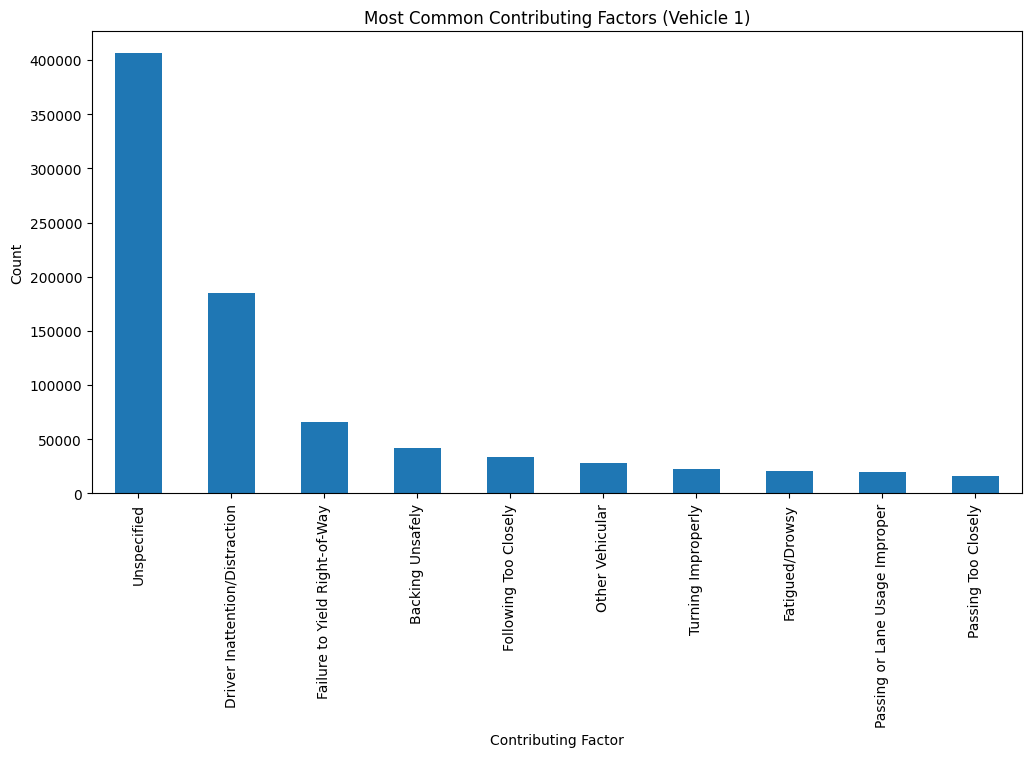

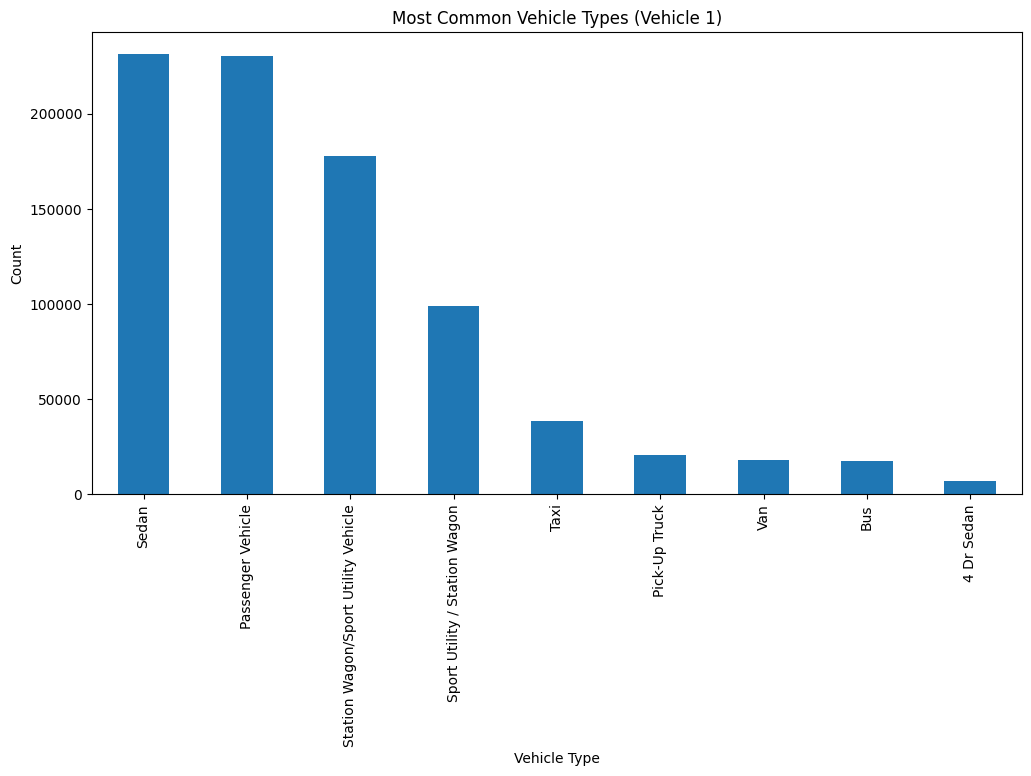

In [112]:
# Creating a bar chart for Contributing Factor Vehicle 1
plt.figure(figsize=(12, 6))
df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().plot(kind='bar')
plt.title('Most Common Contributing Factors (Vehicle 1)')
plt.xlabel('Contributing Factor')
plt.ylabel('Count')
plt.show()

# Creating a bar chart for Vehicle Type Code 1
plt.figure(figsize=(12, 6))
df['VEHICLE TYPE CODE 1'].value_counts().plot(kind='bar')
plt.title('Most Common Vehicle Types (Vehicle 1)')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.show()


In [113]:
# plt.figure(figsize=(12, 6))
# df['HOUR'].value_counts().plot(kind='bar')
# plt.title('Accidents by Hour of Day')
# plt.xlabel('Hour')
# plt.ylabel('Number of Accidents')
# plt.show()


### Clustering

In [114]:
subsample = df.sample(n=50000)

In [115]:
#DBSCAN Documentation: https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

# using latitude and longitude to create clustering
db =  DBSCAN(eps=0.01, min_samples=100, metric='euclidean')
db.fit(subsample[['LATITUDE', 'LONGITUDE']])

# getting labels
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 6
Estimated number of noise points: 1206


In [124]:
# visualizing clusters created by DBSCAN
accident_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10)

for lat,long in zip(df['LATITUDE'], df['LONGITUDE']):
  folium.CircleMarker([lat, long],
                       radius=2,
                       color='red',
                      fill=True,
                      fill_opacity=0.6).add_to(accident_map)

accident_map.save(outfile="accidentmap.html")

## Model Building

In [ ]:
# print(df.isnull().sum())

In [ ]:
df.sample(20)

In [ ]:
# df['CLASS TYPE'].value_counts()

In [ ]:
# df.columns

In [ ]:
# df = pd.get_dummies(df)
# df.sample(10)


In [ ]:
# df.columns

In [ ]:
# X = df.drop('CLASS TYPE', axis=1)
# y = df['CLASS TYPE']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [ ]:
# rfu_model = make_pipeline_imb(
#     RandomUnderSampler(random_state=1234),
#     RandomForestClassifier(random_state=1234)
# )
# rfu_model.fit(X_train, y_train)
# y_pred = rfu_model.predict(X_test)

In [ ]:
# rfu_accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {rfu_accuracy}')

# print(classification_report(y_test, y_pred))

In [ ]:
# with open('rfu_model_two_classes.pkl', 'wb') as f:
#     pickle.dump(y_pred, f)